#### Import packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import inchi
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.ML.Descriptors import MoleculeDescriptors

from pprint import pprint

#### Read data

In [2]:
df = pd.read_csv('data/activity_classes_ChEMBL24.dat', sep='\t')

##### Use data associated with the Histamine H3 receptor

In [3]:
H3 = df[df.TargetName.eq('Histamine H3 receptor')]

In [4]:
H3.head(1)

,TargetID,TargetName,SMILES,AnalogSeriesID,pKi
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96


In [5]:
H3.shape

(961, 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000273EBD82048>]],
      dtype=object)

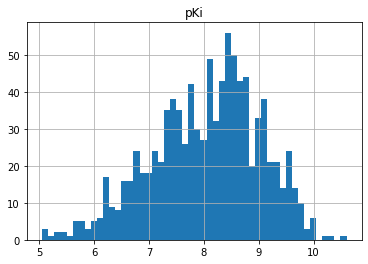

In [6]:
H3.hist('pKi', bins = 50)

#### Build a molecule record from smiles strings

In [7]:
#for index, row in H3.iterrows():
#    H3.loc[index, 'ROMol'] = Chem.MolFromSmiles(row['SMILES'])
PandasTools.AddMoleculeColumnToFrame(H3, smilesCol = "SMILES")

C:\Users\us16120\Anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,TargetID,TargetName,SMILES,AnalogSeriesID,pKi,ROMol
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96,

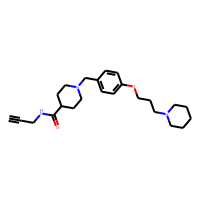

In [8]:
H3.head(1)

#### Calculate fingerprints

In [9]:
radius = 2
nBits = 1024

In [10]:
ECFP4 = [AllChem.GetMorganFingerprintAsBitVect(x, radius = radius, nBits = nBits) for x in H3['ROMol']]

In [11]:
ecfp4_names = [f'Bit_{i}' for i in range(nBits)]
ecfp4_bits = [list(l) for l in ECFP4]
H3_ecfp4 = pd.DataFrame(ecfp4_bits, index = H3.SMILES, columns = ecfp4_names)

In [12]:
H3_ecfp4.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
H3_pKi = H3[['SMILES', 'pKi']]
H3_pKi.set_index('SMILES', inplace = True)

In [14]:
H3_pKi.head(1)

,pKi
SMILES,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96


In [15]:
H3_Xy = H3_pKi.merge(H3_ecfp4, on = 'SMILES')

In [16]:
H3_Xy.head(1)

,pKi,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(H3.loc[1558, 'ROMol'], radius=2, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())[:10]

[2, 13, 80, 93, 102, 197, 257, 310, 322, 550]

In [18]:
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol, bid, bitInfo)))

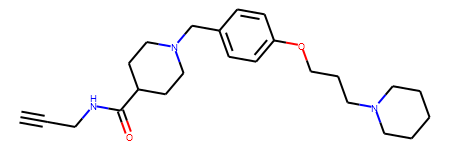

In [19]:
H3.loc[1558, 'ROMol']

In [21]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(H3.loc[1558, 'ROMol']),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(2, 13, 80, 93, 102, 197, 257, 310, 322, 550, 650…

#### Build training and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(H3_Xy.drop(['pKi'], axis = 1), H3_Xy['pKi'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [23]:
X_train.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [24]:
pd.DataFrame(y_train).head(3)

,pKi
SMILES,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,6.97
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,7.46
COc1cccc(n1)c2cc3c(nc2)nc(o3)N4CCC(CC4)N5CCCCC5,7.64


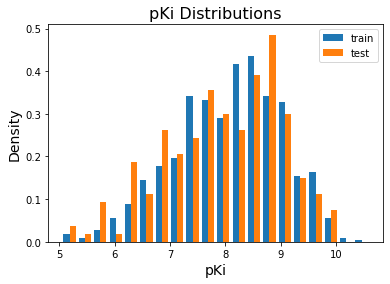

In [25]:
# create dataframe, select columns
df1x = pd.to_numeric(pd.DataFrame(y_train)['pKi'])
df2x = pd.to_numeric(pd.DataFrame(y_test)['pKi'])
#Stack the data
plt.figure()
plt.hist([df1x,df2x], bins = 20, stacked = False, density = True)
plt.title('pKi Distributions', fontsize = 16)
plt.xlabel('pKi', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['train', 'test'])
plt.show()

#### Support Vector Regression

##### Create support vector regressor

In [27]:
svr = SVR()

In [28]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(svr.get_params())

Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


###### ...define grid search

##### Train model ... grid search

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 42.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [38]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [40]:
best_random = rf_random.best_estimator_

In [59]:
best_random.score(X_train, y_train)

0.9967480039312516

In [60]:
best_random.score(X_test, y_test)

0.657239052550656

##### Train model

In [29]:
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [30]:
svr.score(X_train, y_train)

0.8404143093080952

In [31]:
svr.score(X_test, y_test)

0.65202951352901

In [32]:
predict_train = pd.DataFrame(svr.predict(X_train).flatten())
predict_train['set'] = 'train'
predict_test = pd.DataFrame(svr.predict(X_test).flatten())
predict_test['set'] = 'test'

pred = predict_train.append(predict_test)
pred.columns = ['pred', 'set']

expt_train = pd.DataFrame(y_train)
expt_train['set'] = 'train'
expt_test = pd.DataFrame(y_test)
expt_test['set'] = 'test'

expt = expt_train.append(expt_test)
expt.columns = ['expt', 'set']

In [33]:
pred.reset_index(inplace = True, drop = True)
expt.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'Experimental pKi')

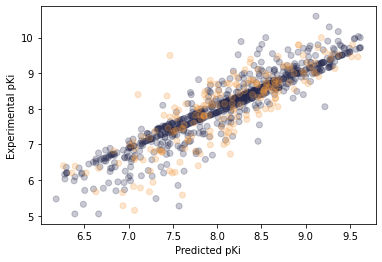

In [34]:
qaz = pd.concat([expt, pred['pred']], axis = 1)

qaz['color'] = np.where(qaz['set'] == 'train', '#26294d', '#f59b3f')

xPlot = qaz['pred']
yPlot = qaz['expt']
colors = qaz['color']

plt.scatter(xPlot, yPlot, c = colors, alpha = 0.25)
plt.xlabel("Predicted pKi")
plt.ylabel("Experimental pKi")

In [36]:
y_pred = svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
rmse

0.38561244701172986

In [37]:
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.6156276496545171

#### SHAP

In [38]:
import shap

In [39]:
# load JS visualization code to notebook
shap.initjs()

In [40]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(svr.predict, shap.sample(X_test, 5))
shap_values = explainer.shap_values(X_test)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


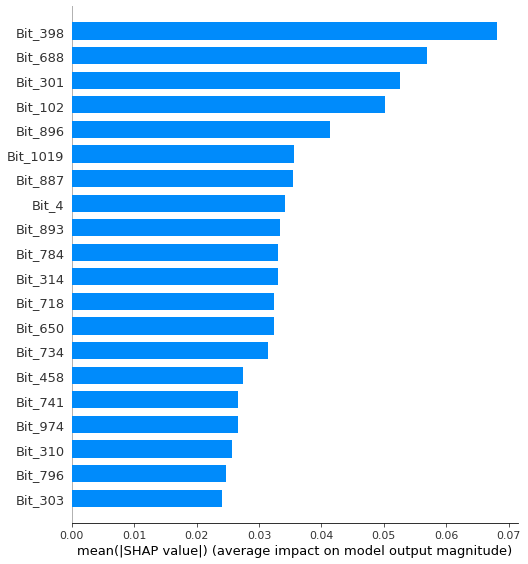

In [43]:
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

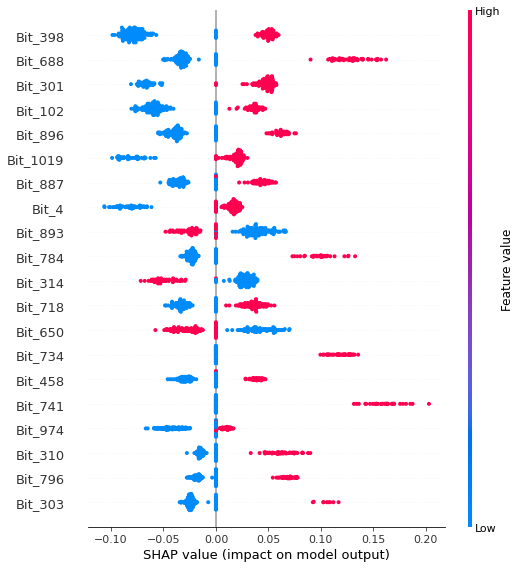

In [44]:
shap.summary_plot(shap_values, X_test)

In [45]:
# Get the predictions and put them in with the test data
X_output = X_test.copy()
X_output.loc[:, 'predict'] = np.round(svr.predict(X_output), 2)

# Randomly pick some observations
random_picks = np.arange(1, 200, 50)
qaz = X_output.iloc[random_picks]
qaz

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,predict
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1CCCN1CCc2ccc3c(c2)ccc(n3)c4cc(no4)C(=O)OC,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,8.65
CC1CC(CN(C1)Cc2ccc(cc2)c3ccc(cc3)CN4CC(CC(C4)C)C)C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7.79
CC(C)NC(=O)N1CCc2ccc(cc2C1)OCCCN3CCCCC3,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.95
Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,9.18


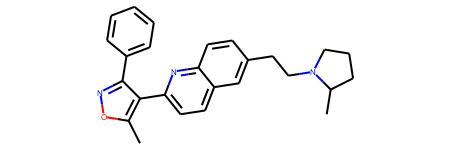

In [54]:
m = Chem.MolFromSmiles('Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C')
m

In [55]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius = 2, nBits = 1024, bitInfo = bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[1,
 4,
 33,
 64,
 72,
 73,
 80,
 104,
 118,
 121,
 136,
 175,
 203,
 219,
 248,
 285,
 301,
 310,
 323,
 342,
 356,
 361,
 363,
 378,
 389,
 446,
 456,
 461,
 471,
 476,
 518,
 545,
 656,
 682,
 690,
 698,
 719,
 723,
 726,
 730,
 734,
 736,
 774,
 831,
 835,
 849,
 875,
 926,
 927,
 935,
 936,
 961,
 980,
 998,
 1015,
 1019]

In [48]:
def shap_plot(j):
#    explainerModel = shap.KernelExplainer(SVR_model, X)
    shap_values_Model = explainer.shap_values(qaz.drop(['predict'], axis = 1))
    p = shap.force_plot(explainer.expected_value, shap_values_Model[j], qaz.drop(['predict'], axis = 1).iloc[[j]])
    return(p)

In [49]:
shap_plot(3)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [56]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(1, 4, 33, 64, 72, 73, 80, 104, 118, 121, 136, 17…